## Are first babies more likely to be late?

Adapted from "Teaching statistical inference with resampling," Copyright 2018 Allen Downey
License: http://creativecommons.org/licenses/by/4.0/

In [12]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(4)

Some people say that first babies are more likely to be late. And some people swear they're early! What's true?

The CDC runs the National Survey of Family Growth (NSFG), which "gathers information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men’s and women’s health." https://www.cdc.gov/nchs/nsfg/index.htm

In [13]:
# Code to get data and into a Pandas Dataframe:
import nsfg

df = nsfg.ReadFemPreg()
df.shape

(13593, 244)

The file contains 13,593 rows, one for each pregnancy reported by a one of the survey respondents, and 244, one for each variable.

Here are the first few lines.

In [14]:
df.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


The variables we need are `outcome`, which indicates whether the pregnancy ended in a live birth, `birthord`, which indicates birth order, and `prglength`, which is pregnancy length in weeks.

From all live births, we can select first babies (`birthord==1`) and others:

In [15]:
live = df[df.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

len(firsts), len(others)

(4413, 4735)

Then we can get the list of pregnancy lengths for the two groups and compute their means:

In [16]:
group1 = firsts.prglngth
group2 = others.prglngth

np.mean(group1), np.mean(group2)

(38.60095173351461, 38.52291446673706)

The difference in means is small, about 0.78 weeks.

In [17]:
diff = group1.mean() - group2.mean()

0.07803726677754952

Which is 13 about hours.

In [18]:
diff * 7 * 24

13.11026081862832

So first babies are born about 13 hours later than other babies, on average. 

## Hypothesis testing

The size of this "apparent effect" is small, and we can't tell whether it is real or the result of random sampling.  After all, we did not survey the entire population; we only surveyed a random sample.

There are two ways the sample might deviate from the population:

*  Systematic errors: The pregnancies included in the survey might be different from other pregnancies in a way that biases the results.

*  Sampling errors: The pregnancies lengths in one groups might be a little higher, or lower, than in the other group because of random variability.

We can never rule out the possibility of systematic errors, but usually we can test whether an apparent effect could be explained by random sampling.

Here's how:

1.  Choose a "test statistics" that measures the size of the effect; in this case, the test statistic we started with is the difference in mean pregnancy length.

2.  Use the data to make a model of the population under the assumption that there is actually no difference between the groups.  This assumption is called the "null hypothesis".

3.  Use the model to simulate the data collection process.

4.  Use the simulated data to compute the test statistic.

4.  Repeat steps 2-4 and collect the results.

5.  See how often the simulated test statistic exceeds the observed difference.

The following function computes the test statistic:

In [19]:
def test_stat(data):
    group1, group2 = data
    return group1.mean() - group2.mean()

Here's how we use it.

In [20]:
data = group1, group2
actual = test_stat(data)

0.07803726677754952

Now we need a model of the population under the assumption that these is actually no difference between the groups.

Well, if there's no difference, we can put the two groups together and shuffle them, then divide them at random into two groups with the same sizes.

That's what this function does:

In [21]:
def run_model(data):
    group1, group2 = data
    pool = np.hstack((group1, group2))
    np.random.shuffle(pool)
    n = len(group1)
    return np.split(pool, [n])

Here's how we run it:

In [22]:
run_model(data)

[array([39, 39, 39, ..., 37, 39, 39]), array([39, 32, 37, ..., 36, 41, 39])]

The result is a list of two arrays, which we can pass to `test_stat`:

In [23]:
test_stat(run_model(data))

-0.054177264016196602

That's the result of one simulated experiment.

We can run the experiment 1000 times and collect the results.

In [24]:
test_stat_dist = np.array([test_stat(run_model(data)) 
                           for i in range(1000)])
np.mean(test_stat_dist)

0.0024876073404128504

The result is the "sampling distribution of the test statistic under the null hypothesis".

The mean of this distribution is close to zero, which is not suprising because it is based on the assumption that there is actually no difference between the groups.

Here's a function to plot the distribution of test stats:

In [25]:
def plot_test_stats(test_stats):
    plt.xlabel('Difference in mean (weeks)')
    plt.title('Distribution of test stat under null hypothesis')
    return plot_hist(test_stats)

In [32]:
def plot_hist(values, low=None, high=None):
    options = dict(alpha=0.5, color='C0')
    xs, ys, patches = plt.hist(values,
                               normed=True,
                               histtype='step', 
                               linewidth=3,
                               **options)
    
    
    plt.ylabel('Density')
    plt.tight_layout()
    return patches[0]

def fill_hist(low, high, patch):
    options = dict(alpha=0.5, color='C0')
    fill = plt.axvspan(low, high, 
                       clip_path=patch,
                       **options)

And here's what it looks like:

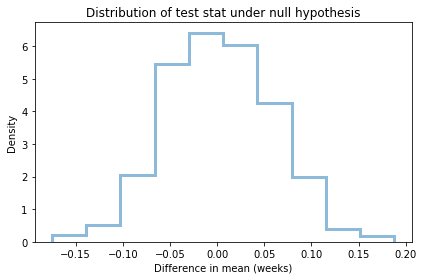

In [33]:
plot_test_stats(test_stat_dist);

Now we can compute the probability that the test statistic, under the null hypothesis, exceeds the observed differences in the means.

This probability is called a "p-value".

In [34]:
p_value = np.mean(test_stat_dist >= actual)

0.094

In this example the p-value is about 8%, which means that the difference we saw, 13 hours, could plausibly occur due to random sampling, even if there is actually no difference between the groups.

The following figure shows the p-value as the shaded area of the distribution above the observed value.

In [35]:
def annotate(text, x, y, length):
    arrowprops = dict(width=1, headwidth=6, facecolor='black')
    plt.annotate(text,
                 xy=(x, y),
                 xytext=(x, y+length),
                 ha='center',
                 arrowprops=arrowprops)

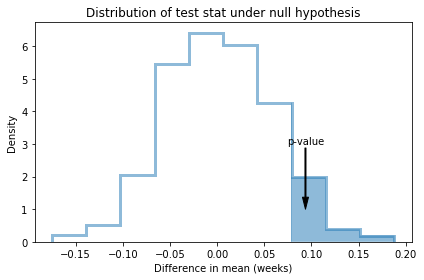

In [36]:
patch = plot_test_stats(test_stat_dist)
low = actual
high = np.max(test_stat_dist)
fill_hist(low, high, patch)
annotate('p-value', 1.2*actual, 1.0, 2)

## Different test statistics

What we computed in the previous section is the probability that first babies would be *later* than 13 hours, on average, under the null hypothesis.

Depending on the context, we might also want to know the probability that first babies would be *earlier* on average.

We can include both possibilities by defining a new test statistic, the *absolute* difference in means.

In [37]:
def test_stat(data):
    group1, group2 = data
    return abs(group1.mean() - group2.mean())

Here's the observed difference with this test stat.

In [38]:
actual = test_stat(data)

0.07803726677754952

Since the actual difference is positive, its absolute value is the same.

We can run the simulated experiments with this test statistic, and print the p-value.

In [39]:
test_stat_dist = np.array([test_stat(run_model(data)) 
                       for i in range(1000)])

p_value = np.mean(test_stat_dist >= actual)

0.16600000000000001

Here's what the distribution looks like for this test statistic.

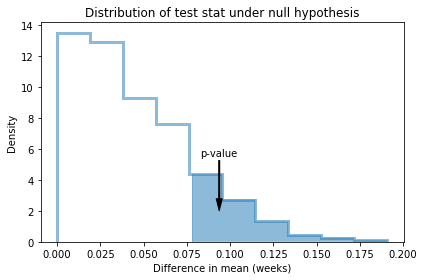

In [40]:
patch = plot_test_stats(test_stat_dist)
low = actual
high = np.max(test_stat_dist)
fill_hist(low, high, patch)
annotate('p-value', 1.2*actual, 2, 3.5)

With this test statistic, the p-value is around 15%, which means is would not be uncommon to see an absolute difference as big as 13 hours, even if there is actually no difference between the groups.

## An object-oriented framework

We can organize the code from the previous sections in a class definition.

In [41]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.actual = self.test_stat(data)
        self.test_stats = np.array([self.test_stat(self.run_model())
                                    for i in range(1000)])

    def p_value(self):
        """Computes the p-value.

        returns: float p-value
        """
        return np.mean(self.test_stats >= self.actual)

    def plot_test_stats(self):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        patch = plot_hist(self.test_stats)
        low = self.actual
        high = np.max(self.test_stats)
        fill_hist(low, high, patch)
        plt.title('Distribution of test stat under null')
        
    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()

The `HypothesisTest` provides implementations for some methods, because they are the same for all hypothesis tests.

But it leaves some methods unimplemented.  We can write child classes to define the unimplemented methods.

For example, `PermutationTest` implements `run_model` by combining the groups and shuffling them:

In [42]:
class PermutationTest(HypothesisTest):
    """Hypothesis test based on permutation."""

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        n = len(self.data[0])
        pool = np.hstack(self.data)
        np.random.shuffle(pool)
        data = np.split(pool, [n])
        return data

`DiffMeansPermute` extends `PermutationTest` and provides `TestStat`:

In [43]:
class DiffMeansPermute(PermutationTest):
    """Tests a difference in means by permutation."""

    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        return abs(group1.mean() - group2.mean())

Now we can test the absolute difference in means by permutation:

Diff means permute pregnancy length
actual = 0.07803726677754952
p-value = 0.189


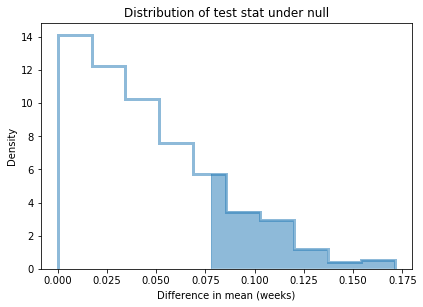

In [44]:
ht = DiffMeansPermute(data)
p_value = ht.p_value()

print('Diff means permute pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in mean (weeks)');

## Different test statistic

It's easy to run a test with a different test statistic.  For example, if we think that first babies might be more variable than others, we could use the difference in standard deviation:

In [45]:
class DiffStdPermute(PermutationTest):
    """Tests a difference in standard deviation by permutation."""

    def test_stat(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        return abs(group1.std() - group2.std())

Here are the results

Diff std permute pregnancy length
actual = 0.1760490642294399
p-value = 0.169


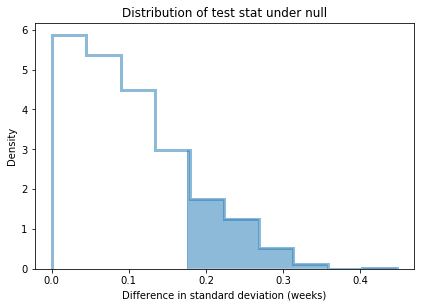

In [46]:
ht = DiffStdPermute(data)
p_value = ht.p_value()

print('Diff std permute pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in standard deviation (weeks)');

The observed difference in standard deviation is about 0.17 weeks.

The p-value is around 17%, which indicates that, even if there is actually no difference between the groups, there is a non-negligible chance that we could see a difference in standard deviation as big as 0.17 weeks due to random sampling.

## Different model

It's also easy to run with a different model.  Instead of shuffling the observed data, we could use the data to choose the parameters of a normal distribution, and then draw random samples:

In [47]:
class RandomNormalTest(HypothesisTest):
    """Tests by drawing values from a normal distribution."""

    def run_model(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        n = len(self.data[0])
        pool = np.hstack(self.data)
        mu, sigma = np.mean(pool), np.std(pool)
        random = np.random.normal(mu, sigma, len(pool))
        data = np.split(random, [n])
        return data

Now we can make a class that tests a difference in means by drawing values from a normal distribution:

In [48]:
class DiffMeansNormal(PermutationTest):
    """Tests a difference in means using a normal distribution."""
    
    test_stat = DiffMeansPermute.test_stat

And here are the results:

Diff means normal pregnancy length
actual = 0.07803726677754952
p-value = 0.167


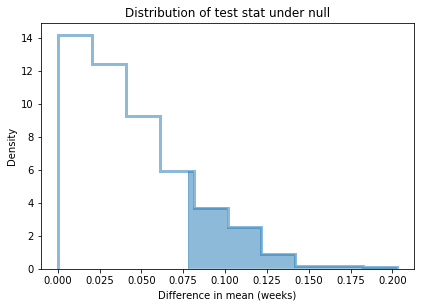

In [49]:
ht = DiffMeansNormal(data)
p_value = ht.p_value()

print('Diff means normal pregnancy length')
print('actual =', ht.actual)
print('p-value =', p_value)
ht.plot_test_stats()
plt.xlabel('Difference in mean (weeks)');

The results from this model are not substantially different, which suggests that they do not depend on arbitrary modeling decisions, and that's good.

For this example, the permutation test is probably better because it does not make any assumptions about the distribution of pregnancy lengths.

If the sample size were substantially smaller, the model that draws from the normal distribution might be better.